In [1]:
import pandas as pd
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.stats.stattools import durbin_watson
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

%load_ext autoreload
%autoreload 2

In [24]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update(mpl.rcParamsDefault)
# mpl.rcParams["text.usetex"] = True
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.size"] = "10"

In [3]:
from utils import (
    adf_test,
    kpss_test,
    grangers_causation_matrix,
    adjust,
    cointegration_test,
    splitter,
    create_plot,
    forecast_accuracy
)


### Loading the Dataset

In [6]:
ts_prices_btc = pd.read_csv("Data/Time_Series/prices/bitcoin_19_22.csv",index_col='date',parse_dates=['date'])

In [7]:
crypto = 'crypto_bitcoin'
# crypto = 'crypto_ethereum'
# crypto = 'crypto_xrp'

In [8]:
model ='VADER'
df = pd.read_csv(f"Data/Time_Series/{crypto}/{model}_sts_19_22.csv",index_col='posted_on',parse_dates=['posted_on'])

In [9]:
df.columns

Index(['positive_count', 'negative_count', 'neutral_count', 'total_posts',
       'total_words', 'total_stopwords', 'total_comments',
       'average_word_length', 'mean_vader_score'],
      dtype='object')

In [10]:
ts_prices_btc=ts_prices_btc.join(df)

In [17]:
# Remove Neutral Time Series
for c in ts_prices_btc.columns:
    if 'mean' in c.lower() or 'neutral' in c.lower():
        print(f"Dropping column {c}")
        ts_prices_btc.drop(c,axis=1,inplace=True)

Dropping column mean_vader_score


In [12]:
# Filtering data for only 2022
ts_prices_btc = ts_prices_btc[ts_prices_btc.index.year == 2022]
ts_prices_btc.index.year.unique()

Int64Index([2022], dtype='int64', name='date')

In [13]:
ts_prices_btc.head(5)

,price,positive_count,negative_count,total_posts,total_words,total_stopwords,total_comments,average_word_length,mean_vader_score
date,,,,,,,,,
2022-01-01,46319.65,40,10,71,7628,3018,7782,5.443135,0.372006
2022-01-02,47816.08,34,10,70,8501,3226,3738,5.627238,0.374646
2022-01-03,47387.21,60,13,96,11417,4498,5290,5.619037,0.424801
2022-01-04,46531.14,46,8,83,9083,3502,4849,5.606973,0.396975
2022-01-05,45938.02,66,11,110,10862,4382,6430,5.487421,0.428415


In [14]:
df = ts_prices_btc

In [15]:
df.isna().sum()

price                  0
positive_count         0
negative_count         0
total_posts            0
total_words            0
total_stopwords        0
total_comments         0
average_word_length    0
mean_vader_score       0
dtype: int64

### VAR Model with only 2022 data

In [16]:
df=ts_prices_btc
# Checking for Stationarity
for i in range(0,len(df.columns)):
    # fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
    # ax1, ax2 = axes.flatten()
    print('Series:', df.columns[i])
    # plot_acf(ts_prices_btc.iloc[1:,i], lags=60, zero=False, alpha=.05, title='Autocorrelation Plot', ax=ax1)
    # plot_pacf(ts_prices_btc.iloc[1:,i], lags=60, zero=False, alpha=.05, title='Partial Autocorrelation Plot', ax=ax2)
    # plt.show()
    adf_test(df.iloc[:,i])
    kpss_test(df.iloc[:,i])
    print("*"*100)

Series: price
Augmented Dicky Fuller Test
	Result: The series is non-stationary
KPSS Test
	Result: The series is non-stationary
****************************************************************************************************
Series: positive_count
Augmented Dicky Fuller Test
	Result: The series is non-stationary
KPSS Test
	Result: The series is non-stationary
****************************************************************************************************
Series: negative_count
Augmented Dicky Fuller Test
	Result: The series is stationary
KPSS Test
	Result: The series is non-stationary
****************************************************************************************************
Series: total_posts
Augmented Dicky Fuller Test
	Result: The series is stationary
KPSS Test
	Result: The series is non-stationary
****************************************************************************************************
Series: total_words
Augmented Dicky Fuller Test
	Result: The series 

Since some of the time series are not stationary, we'll have to take first difference

In [18]:
df_first_differenced = df.diff().dropna()

In [19]:
df_first_differenced.head(2)

,price,positive_count,negative_count,total_posts,total_words,total_stopwords,total_comments,average_word_length
date,,,,,,,,
2022-01-02,1496.43,-6.0,0.0,-1.0,873.0,208.0,-4044.0,0.184102
2022-01-03,-428.87,26.0,3.0,26.0,2916.0,1272.0,1552.0,-0.008201


In [20]:
for i in range(0,len(df_first_differenced.columns)):
    # fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
    # ax1, ax2 = axes.flatten()
    print('Series:', df_first_differenced.columns[i])
    # plot_acf(ts_prices_btc.iloc[1:,i], lags=60, zero=False, alpha=.05, title='Autocorrelation Plot', ax=ax1)
    # plot_pacf(ts_prices_btc.iloc[1:,i], lags=60, zero=False, alpha=.05, title='Partial Autocorrelation Plot', ax=ax2)
    # plt.show()
    adf_test(df_first_differenced.iloc[:,i])
    kpss_test(df_first_differenced.iloc[:,i])
    print("*"*100)

Series: price
Augmented Dicky Fuller Test
	Result: The series is stationary
KPSS Test
	Result: The series is stationary
****************************************************************************************************
Series: positive_count
Augmented Dicky Fuller Test
	Result: The series is stationary
KPSS Test
	Result: The series is stationary
****************************************************************************************************
Series: negative_count
Augmented Dicky Fuller Test
	Result: The series is stationary
KPSS Test
	Result: The series is stationary
****************************************************************************************************
Series: total_posts
Augmented Dicky Fuller Test
	Result: The series is stationary
KPSS Test
	Result: The series is stationary
****************************************************************************************************
Series: total_words
Augmented Dicky Fuller Test
	Result: The series is stationary
KPSS Test


In [21]:
gc_res = grangers_causation_matrix(df_first_differenced, variables = df_first_differenced.columns, maxlag=40)    

In [22]:
def negative_grey(val):
    color = 'grey' if val < 0.05 else ''
    return 'background-color:' + color  

def negative_bold(val):
    bold = 'bold' if val < 0.05 else ''
    return 'font-weight: %s' % bold

gc_res.style.applymap(negative_grey).applymap(negative_bold)

,price_x,positive_count_x,negative_count_x,total_posts_x,total_words_x,total_stopwords_x,total_comments_x,average_word_length_x
price_y,1.000000,0.032800,0.044300,0.008800,0.157100,0.231400,0.057000,0.408400
positive_count_y,0.000100,1.000000,0.012000,0.000000,0.095900,0.060400,0.000200,0.036700
negative_count_y,0.000000,0.000700,1.000000,0.000000,0.002100,0.002800,0.001400,0.009100
total_posts_y,0.002300,0.000900,0.255600,1.000000,0.164000,0.332400,0.008800,0.120900
total_words_y,0.000000,0.000900,0.003700,0.000000,1.000000,0.251700,0.000100,0.000100
total_stopwords_y,0.000000,0.001200,0.003200,0.000000,0.527100,1.000000,0.000100,0.000200
total_comments_y,0.000000,0.001200,0.165500,0.032300,0.012000,0.005500,1.000000,0.070500
average_word_length_y,0.005800,0.041500,0.003400,0.002600,0.006900,0.010100,0.003700,1.000000


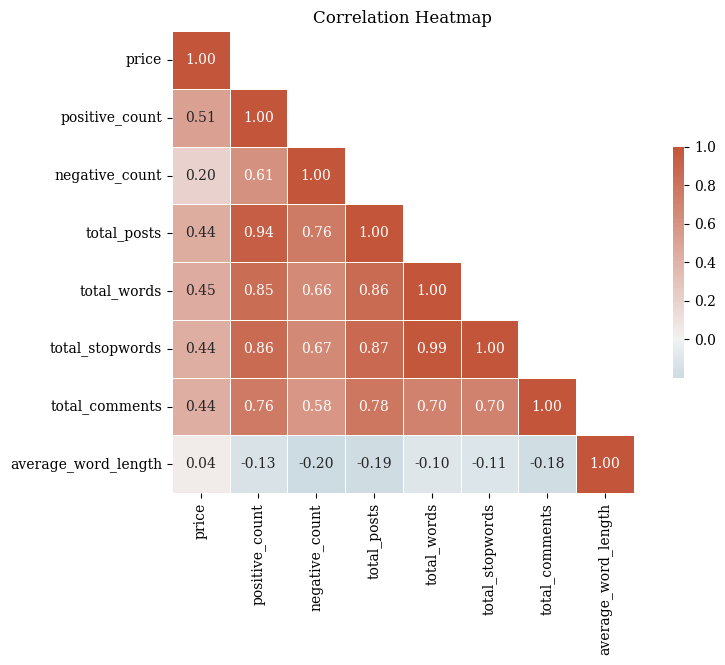

In [25]:
import numpy as np
# import matplotlib.pyplot as plt
import seaborn as sns

correlation_matrix = df.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool),k=1)

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=1, center=0, annot=True, fmt=".2f",
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Add title
plt.title('Correlation Heatmap')

# Show the heatmap
plt.show()

In [26]:
df_first_differenced = df_first_differenced[['price', 'negative_count', 'total_posts',
       'total_words','total_comments']]

In [27]:
cointegration_test(df_first_differenced)

Name                           ::  Test Stat > C(95%)    =>  Signif 
 ----------------------------------------------------------------------
price                          ::  652.95    > 60.0627   =>   True
negative_count                 ::  469.79    > 40.1749   =>   True
total_posts                    ::  310.61    > 24.2761   =>   True
total_words                    ::  171.86    > 12.3212   =>   True
total_comments                 ::  63.23     > 4.1296    =>   True


In [28]:
train_df, test_df = splitter(df_first_differenced)
nobs = len(test_df)

In [29]:
train_df.index[0],train_df.index[-1], len(train_df)

(Timestamp('2022-01-02 00:00:00'), Timestamp('2022-10-19 00:00:00'), 291)

In [30]:
test_df.index[0],test_df.index[-1],len(test_df)

(Timestamp('2022-10-20 00:00:00'), Timestamp('2022-12-31 00:00:00'), 73)

In [32]:
model = VAR(train_df)
x = model.select_order(maxlags=30)
x.summary()

,AIC,BIC,FPE,HQIC
0,50.43,50.50,7.997e+21,50.46
1,49.52,49.93,3.195e+21,49.68
2,49.11,49.86*,2.138e+21,49.42
3,48.95,50.04,1.815e+21,49.39*
4,48.84*,50.28,1.631e+21*,49.42
5,48.85,50.63,1.653e+21,49.57
6,48.84,50.96,1.640e+21,49.69
7,48.92,51.38,1.780e+21,49.91
8,48.91,51.71,1.760e+21,50.03
9,48.99,52.13,1.921e+21,50.25


In [33]:
model_fitted = model.fit(4)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 24, Jun, 2024
Time:                     13:23:59
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    50.7244
Nobs:                     287.000    HQIC:                   49.9221
Log likelihood:          -9018.00    FPE:                2.80825e+21
AIC:                      49.3855    Det(Omega_mle):     1.97284e+21
--------------------------------------------------------------------
Results for equation price
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                  -101.124046        67.115094           -1.507           0.132
L1.price                 -0.001983         0.062363           -0.032           0.975
L1.negative_count        34.861195        21

In [34]:
irf = model_fitted.irf(periods=8)

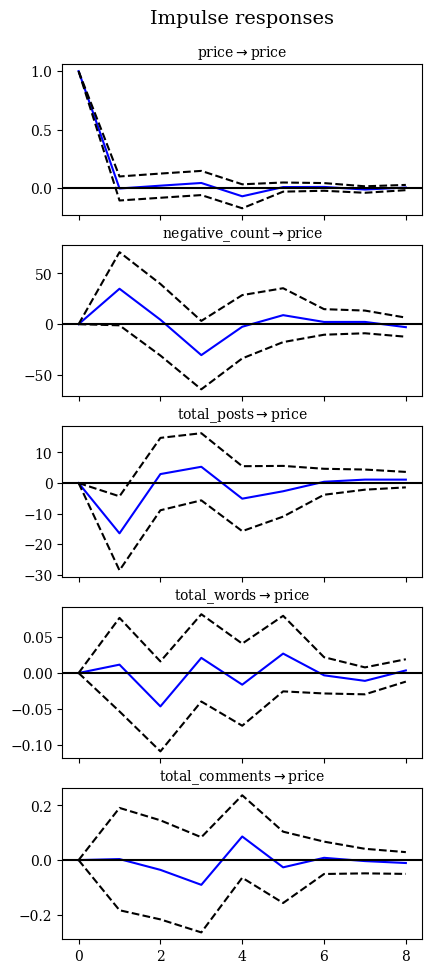

In [62]:
irf.plot(orth=False, 
        response='price',
        signif=0.10,
        figsize=(4, 10),
        subplot_params={'fontsize': 10})

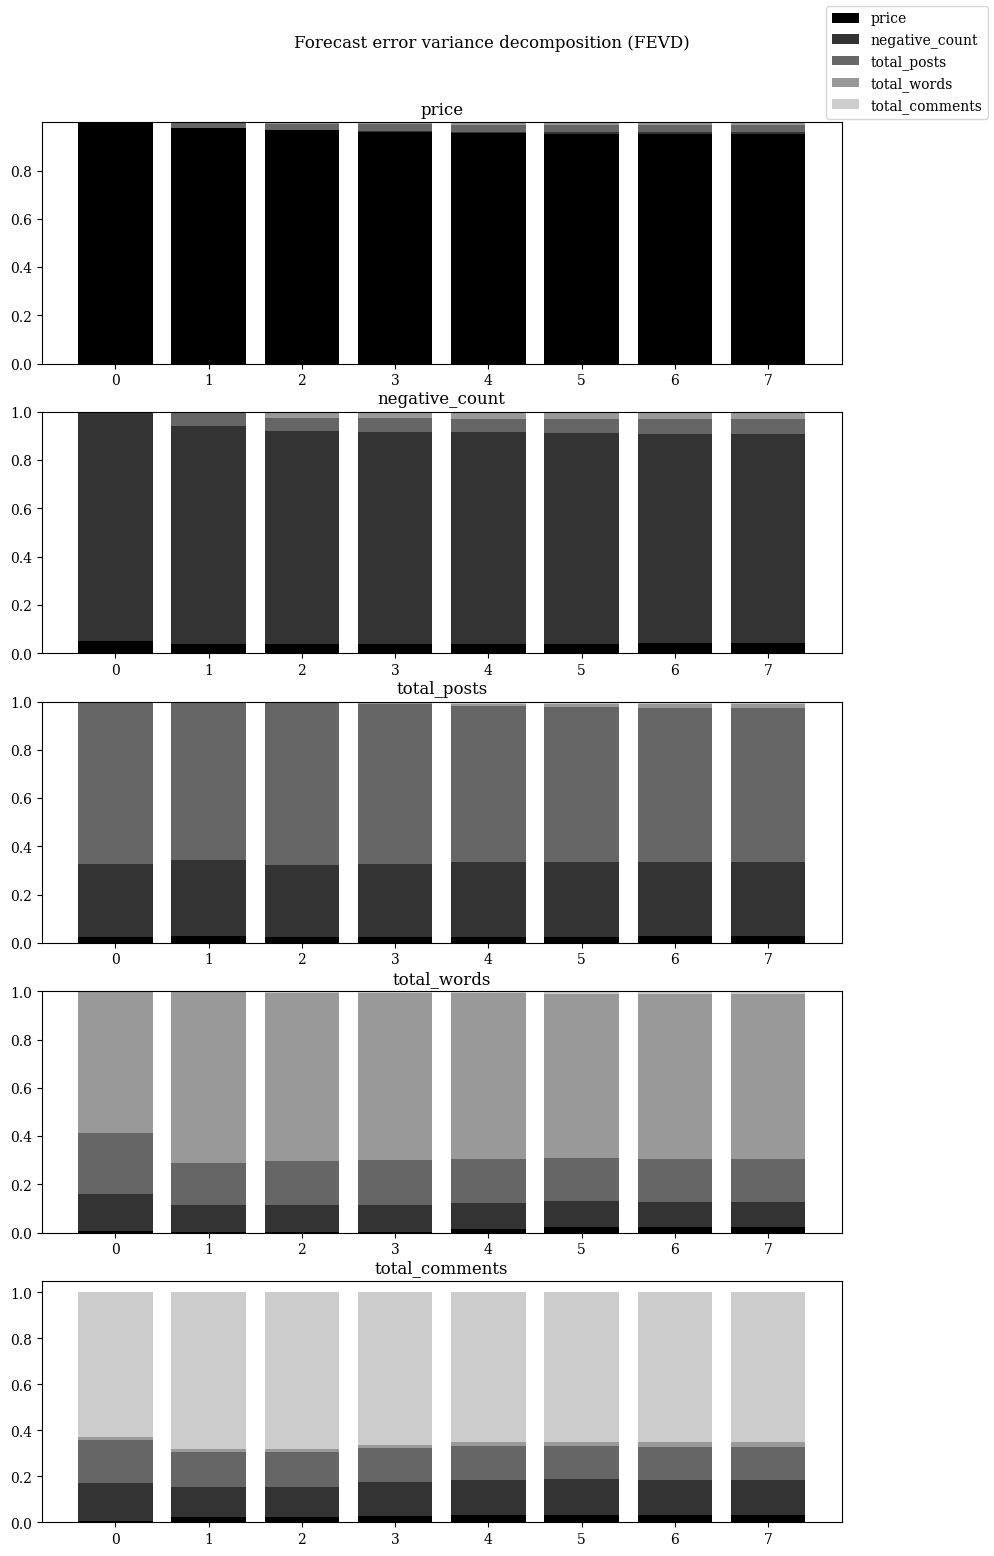

In [44]:
fevd = model_fitted.fevd(8)
fevd.plot(figsize=(10, 16))
# plt.xticks(fontsize=5)
# plt.yticks(fontsize=5)
# plt.show()

In [60]:
# Input data for forecasting
lag_order=model_fitted.k_ar
forecast_input = train_df.values[-lag_order:]
forecast_input

array([[-1.2533e+02, -2.0000e+00,  1.0000e+00,  1.8420e+03, -1.9000e+01],
       [ 2.0014e+02,  5.0000e+00,  2.0000e+01,  4.8110e+03,  4.5000e+02],
       [ 2.8498e+02, -4.0000e+00, -1.3000e+01, -5.4250e+03, -3.2700e+02],
       [-2.0987e+02,  1.0000e+00, -2.0000e+00,  2.0000e+01,  3.9000e+02]])

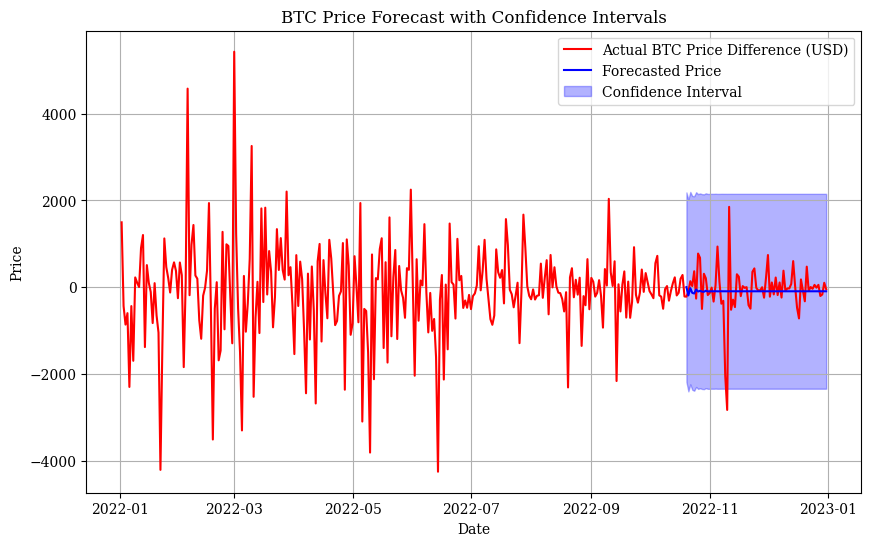

In [47]:
forecast_steps = 73
forecast_result = model_fitted.forecast_interval(forecast_input, steps=forecast_steps)

# Extract the forecast and confidence intervals
forecast_values = forecast_result[0]
lower_bound = forecast_result[1]
upper_bound = forecast_result[2]

# Extract the 'price' variable forecast
price_forecast = forecast_values[:, 0]
price_lower = lower_bound[:, 0]
price_upper = upper_bound[:, 0]

# Create a date range for the forecast
# forecast_dates = pd.date_range(start=df.index[-1], periods=forecast_steps+1, closed='right')

# # Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df_first_differenced.index, df_first_differenced['price'], label='Actual BTC Price Difference (USD)',color='red')
plt.plot(test_df.index, price_forecast, label='Forecasted Price', color='blue')
plt.fill_between(test_df.index, price_lower, price_upper, color='blue', alpha=0.3, label='Confidence Interval')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('BTC Price Forecast with Confidence Intervals')
plt.legend()
plt.grid()
plt.show()

In [48]:
out = durbin_watson(model_fitted.resid)

for col, val in zip(df_first_differenced.columns, out):
    print(adjust(col), ':', round(val, 2))

price  : 2.03
negative_count : 2.0
total_posts : 2.03
total_words : 2.06
total_comments : 2.01


In [49]:
fc = model_fitted.forecast(y=forecast_input, steps=nobs)

In [50]:
forecast = pd.DataFrame(model_fitted.forecast(y= forecast_input, steps=nobs), index = test_df.index,columns = test_df.columns)

In [51]:
forecast.iloc[0]

price               5.203319
negative_count      0.172688
total_posts        -2.545156
total_words       623.186951
total_comments   -547.042292
Name: 2022-10-20 00:00:00, dtype: float64

In [52]:
df_first_differenced.iloc[290]

price            -209.87
negative_count      1.00
total_posts        -2.00
total_words        20.00
total_comments    390.00
Name: 2022-10-19 00:00:00, dtype: float64

In [53]:
df_first_differenced.columns

Index(['price', 'negative_count', 'total_posts', 'total_words',
       'total_comments'],
      dtype='object')

In [54]:
row = df.iloc[[0]][['price', 'negative_count', 'total_posts', 'total_words', 'total_comments']]
row

,price,negative_count,total_posts,total_words,total_comments
date,,,,,
2022-01-01,46319.65,10,71,7628,7782


In [55]:
# Invert Transformation
df_result = pd.concat([df_first_differenced.iloc[:291],forecast]) 
df_result = pd.concat([row,df_result]).cumsum()

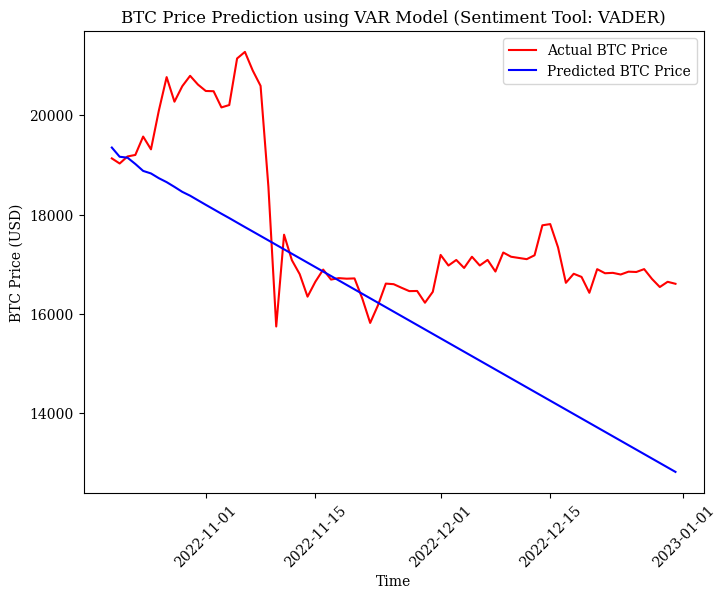

In [56]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(ts_prices_btc['price'].iloc[-nobs:], color = 'red', label = 'Actual BTC Price')
plt.plot(df_result['price'].iloc[-nobs:], color = 'blue', label = 'Predicted BTC Price')
plt.title('BTC Price Prediction using VAR Model (Sentiment Tool: VADER)')
plt.xlabel('Time')
plt.xticks(rotation=45)
plt.ylabel('BTC Price (USD)')
plt.legend()
plt.show()

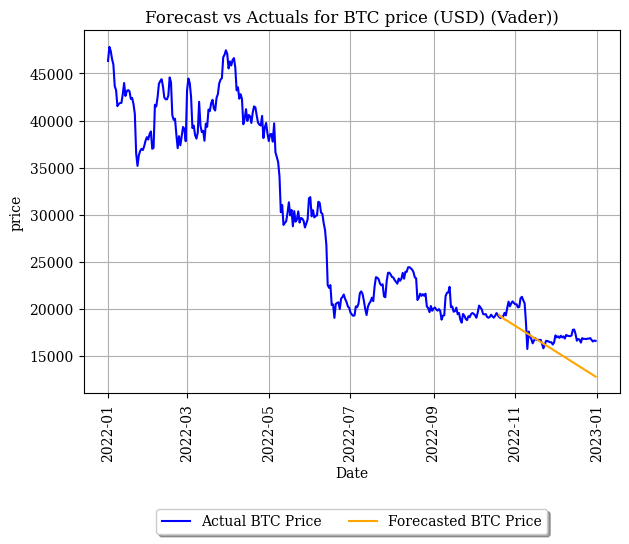

In [57]:
data_predicted = df_result['price'][-nobs:]
data_actual = df['price']
create_plot(data_predicted, data_actual, 'BTC', 'Vader')

In [59]:
print('Forecast Accuracy of: BTC Price')
# accuracy_prod = 
res = forecast_accuracy(data_predicted.values, data_actual[-nobs:],['BTC_ModelA'])
res

Forecast Accuracy of: BTC Price


,MAE,MAPE,MSE,RMSE
BTC_ModelA,1822.636688,10.255347,4.899262e+06,2213.427558
